# Plot Supp Figures - CC

CC plots 

For Sawi et al., 2021

In [1]:
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from obspy import read
from matplotlib import cm
import matplotlib.gridspec as gridspec
import os
import datetime as dtt
import matplotlib.patches
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
from  sklearn.preprocessing import StandardScaler
import sys
from matplotlib.patches import Rectangle
import sklearn.metrics
from scipy import spatial
import matplotlib.image as mpimg
import obspy
from scipy.signal import butter, lfilter
import librosa
# sys.path.insert(0, '../01_DataPrep')
from scipy.io import loadmat
from sklearn.decomposition import PCA
import scipy.io as spio
from sklearn.metrics import silhouette_samples
import seaborn as sns
import scipy as sp
import scipy.io as spio
import scipy.signal
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from obspy.signal.cross_correlation import correlate, xcorr_max


sys.path.append('.')
sys.path.append('../src/visualization/')

import paths
from sklearn.cluster import KMeans
# import figureFunctions

In [2]:


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat,calcCCMatrix
from functions2 import dateToEventID, catMergeFromH5, calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF
import figureFunctions2


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat,calcCCMatrix
from functions2 import catMergeFromH5, swapLabels, calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF
import figureFunctions2

## Define helper functions (move later)

## Set paths

In [3]:
#%% load project variables: names and paths
# key = sys.argv[1]

key = "BB_Gorner_Event_Final_v11_J8"
keyN = "BB_Gorner_Cont_Final_v10_J8"


filetype = '.gse2'     
filetypeN = '.sac' 


p = paths.returnp(key)
pN = paths.returnp(keyN)

#%%

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
path_WF         = p['path_WF']
path_Cat        = p['path_Cat'] #original, raw catalog
subCatalog_Name = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"



pathFP          = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEB          = f'{path_top}{projName}/02_src/02_SpecUFEx/EB.mat'
pathElnB          = f'{path_top}{projName}/02_src/02_SpecUFEx/ElnB.mat'
pathW        = path_proj + '02_src/02_SpecUFEx/out.DictGain.mat' 


# pathClusCat = path_proj + f"principalDf_full_{mode}_Kopt{Kopt}.csv"
dataH5_path = path_proj + dataFile_name


projNameN        = pN['projName']
datasetIDN       = pN['datasetID']
projNameN        = pN['projName']
station         = pN['station']
channel         = pN['channel']


path_top        = pN['path_top']
path_projN       = pN['path_proj']
outfile_nameN    = pN['outfile_name']
dataFile_nameN   = pN['dataFile_name']
path_WFN         = pN['path_WF']
path_CatN        = pN['path_Cat'] #original, raw catalog
subCatalog_NameN = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"


pathACMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/EB.mat'
pathElnBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/ElnB.mat'
pathWN        = path_projN + '02_src/02_SpecUFEx/out.DictGain.mat' 



# pathClusCatN = path_projN + f"principalDf_full_{mode}_Kopt{KoptN}.csv"
dataH5_pathN = path_projN + dataFile_nameN

pathFigSupp = '../reports/supp_figures/'

pathFig = '../reports/figures/'
pathAuxData = '../data/processed/Garcia/'

In [4]:
## Load auxiliary catalog

gps_station_list = ['24','34','36','37']
gps_df_list = []

for gst in gps_station_list:
    
    
    gps_df = pd.read_csv(f'{pathAuxData}gps_roll{gst}.csv',index_col=0)
    gps_df['datetime'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df['datetime_index'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df = gps_df.set_index('datetime_index')
    
    
    gps_df_list.append(gps_df)


lake_df = pd.read_csv(f'{pathAuxData}lake_df.csv',index_col=0)
lake_df['datetime'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df['datetime_index'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df = lake_df.set_index('datetime_index')


meteor_df = pd.read_csv(f'{pathAuxData}meteor_df.csv',index_col=0)
meteor_df['datetime'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df['datetime_index'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df = meteor_df.set_index('datetime_index')



## Define some important times in study period

In [5]:
# timing of lake events 
tstart = dtt.datetime(2007, 6, 13)
tend = dtt.datetime(2007, 7, 23)
calvet = dtt.datetime(2007, 7, 1,13,41,35)
supraDraint = dtt.datetime(2007, 7, 4)
subDraint = dtt.datetime(2007, 7, 7)
drainEndt = dtt.datetime(2007, 7, 15)


## Load original catalogs

In [6]:
cat00 = catMergeFromH5(path_Cat,path_proj,outfile_name)
cat00N = catMergeFromH5(path_CatN,path_projN,outfile_nameN)

1411 events kept, merge sucessful
1521 events kept, merge sucessful


## Get experiment parameters from H5 file

In [7]:
#########       #########       #########       #########       #########       #########       #########       #########       

####IQIQIQIQIQIQIQIQI

#########       #########       #########       #########       #########       #########       #########       #########       



with h5py.File(path_proj + dataFile_name,'r') as dataFile:

    lenData = dataFile['processing_info/'].get('lenData')[()]
    fs = dataFile['spec_parameters/'].get('fs')[()]
    
    # fmin = 
    nperseg = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlap = dataFile['spec_parameters/'].get('noverlap')[()]
    nfft = dataFile['spec_parameters/'].get('nfft')[()]


    fmax = dataFile['spec_parameters/'].get('fmax')[()]
    fmax = np.ceil(fmax)
    fmin = dataFile['spec_parameters/'].get('fmin')[()]
    fmin = np.floor(fmin)    
    fSTFT = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFT = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_mode = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scaling = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fs = int(np.ceil(fs))
winLen_Sec = float(nperseg / fs)


#########       #########       #########       #########       #########       #########       #########       #########       

##### NOISENOISENOISENOISENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


with h5py.File(path_projN + dataFile_nameN,'r') as dataFile:

    lenDataN = dataFile['processing_info/'].get('lenData')[()]
    fsN = dataFile['spec_parameters/'].get('fs')[()]
    
    # fminN = 
    npersegN = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlapN = dataFile['spec_parameters/'].get('noverlap')[()]
    nfftN = dataFile['spec_parameters/'].get('nfft')[()]


    fmaxN = dataFile['spec_parameters/'].get('fmax')[()]
    fmaxN = np.ceil(fmaxN)
    fminN = dataFile['spec_parameters/'].get('fmin')[()]
    fminN = np.floor(fminN)    
    fSTFTN = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFTN = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_modeN = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scalingN = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fsN = int(np.ceil(fsN))
winLen_SecN = float(npersegN / fsN)



## Format day ticks, time plotting

* Central European Time is 2 hours later than UTC (Coordinated Universal Time) 
* Max temp occurs around 16:00 (4pm) local time or, 14:00 (2pm) UTC
* All times in UTC


todo: fix ::


##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat0.event_ID.resample('D', label='left', closed='right').count()

In [8]:


############################################################
            ##### FORMAT DAY TICKS (ASSUMES NO DAYS SKIPPED?) ######
############################################################
tstart = pd.to_datetime('2007-06-14 00:00:00')
tend   = pd.to_datetime('2007-07-22 00:00:00')



delta_day = 7

##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat00.event_ID.resample('D', label='left', closed='right').count()

numDays = len(clus_clu_perday)

days_list = [clus_clu_perday.index[i] for i in range(numDays)]


## these have lots of possible text formats
day_labels = [f"{days_list[d].month}-{days_list[d].date().day}" for d in range(0,len(days_list),delta_day)]

day_ticks = [days_list[d] for d in range(0,len(days_list),delta_day)]


# Central European Time is 2 hours later than UTC (Coordinated Universal Time)
##max temp is around 4pm local time or 16:00, in UTC it is 14:00 or 2pm
#all times in UTC
hour_of_approx_max_temp = 14
hourMaxTemp = [dtt.datetime(2007, 6, 14,hour_of_approx_max_temp,0,0) + pd.DateOffset(i) for i in range(0,numDays)]

hour24labels = [str(r) for r in range(0,24)] #UTC

print(day_labels)
############################################################
############################################################

       

['6-14', '6-21', '6-28', '7-5', '7-12', '7-19']


In [9]:
plt.rcParams['image.cmap']='magma'

plt.rcParams.update({'font.size': 8})
colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))


## when plotting, add a bit of buffer so bars aren't cut off
tlimstart = pd.to_datetime('2007-06-13 12:00:00')
tlimend   = pd.to_datetime('2007-07-22 12:00:00')


lw1=4        
lw2=5
alphaT=1
ylabfont=8
ylabpad =10


plt_kwargs = {'lw1':lw1,
              'lw2':lw2,
              'alphaT':alphaT,
              'ylabfont':ylabfont,
              'ylabpad':ylabpad,
              'colors':colors,
              'scaling':scaling,
              'sgram_mode':sgram_mode,
              'hour24labels':hour24labels,
              'day_ticks':day_ticks,
              'day_labels':day_labels,
              'numDays':numDays,
              'hourMaxTemp':hourMaxTemp,
              'tstart':tlimstart, ## for extending x axis to fit bars
              'tend':tlimend,     ## for extending x axis to fit bars
              'tstartreal':tstart,## actual study bound
              'tendreal':tend     ## actual study bound
             }

## Specs for figures JGR

In [10]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

# Reduce dimensionality, visualize PC plots by time, hour

* Perform PCA on FPs 
* Calculate PVE (percent variance explained) for each PC, and keep enouch PCs to capture XX% of variance
* Cluster using Kmeans 
* Choose cluster based on highest mean silhouette score


In [11]:
numStates=15
PCA_df, numPCA_PVE, cum_pve = PVEofPCA(path_proj,outfile_name,cat00,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False);
PCA_dfN, numPCA_PVEN, cum_pveN = PVEofPCA(path_projN,outfile_nameN,cat00N,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False)



1 0.141772319308
2 0.225535762941
3 0.277379352922
4 0.312981182247
5 0.343504120995
6 0.372574681896
7 0.398888835673
8 0.420888419046
9 0.439349093698
10 0.456414532179
11 0.472881750608
12 0.48865332609
13 0.503517818175
14 0.517480341072
15 0.53075489761
16 0.543724834707
17 0.5562871587
18 0.568379959341
19 0.580147786654
20 0.591292868621
21 0.602312262237
22 0.612610947945
23 0.621994135208
24 0.629969362037
25 0.639999459174
26 0.648601690927
27 0.657313227011
28 0.665405604441
29 0.673156862875
30 0.680781136601
31 0.687751414276
32 0.694490874664
33 0.701711426885
34 0.708680764806
35 0.715594105465
36 0.722445215354
37 0.728756462458
38 0.734990221371
39 0.74092854244
40 0.747130687112
41 0.752473787084
42 0.758629983258
43 0.763761251859
44 0.769336768505
45 0.775104061458
46 0.780146970159
47 0.784839716292
48 0.789831693811
49 0.794648831575
50 0.799364537044
51 0.80378702853
52 0.808390055749
53 0.812209997121
54 0.816799919711
55 0.820876494218
56 0.824947364719
57 0.82

In [12]:
print(f'\n For icequakes, {100*cum_pve:.2f}% of variance explained by the first {numPCA_PVE} principal components')
print(f'\n For noise, {100*cum_pveN:.2f}% of variance explained by the first {numPCA_PVEN} principal components')


 For icequakes, 86.00% of variance explained by the first 66 principal components

 For noise, 86.09% of variance explained by the first 3 principal components


In [13]:
stand = False #standard scalar before PCA


#returns a PCA sklearn object, a dataframe of cat00 but with columns for PCs, and a numpy array of PCs (N x numPC)

sklearn_pca, cat00, Y_PCA = PCAonFP(path_proj,outfile_name,cat00,numPCA=numPCA_PVE,stand=stand)
sklearn_pcaN, cat00N, Y_PCAN = PCAonFP(path_projN,outfile_nameN,cat00N,numPCA=numPCA_PVEN,stand=stand)


## Clustering using Kmeans on PCA of FP, validating using silhouette score

In [14]:
## silh score and validation
##making rep catalog


##can force K here
Kmax=10
range_n_clusters_all = list(range(2,Kmax+1))


cat00, catall, Kopt, maxSilScore, avgSils, sse,cluster_labels_best,ss_best,euc_dist_best = calcSilhScore(path_proj,outfile_name,cat00,range_n_clusters_all,numPCA=numPCA_PVE,Xtype='fingerprints', distMeasure = "SilhScore",stand=stand);

print('Event optimum number of clusters:: ',Kopt)


cat00N, catallN, KoptN, maxSilScoreN, avgSilsN, sseN,cluster_labels_bestN,ss_bestN,euc_dist_bestN = calcSilhScore(path_projN,outfile_nameN,cat00N,range_n_clusters_all,numPCA=numPCA_PVEN,Xtype='fingerprints',distMeasure = "SilhScore", stand=stand);


print('Noise optimum number of clusters:: ',KoptN)


kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 3
Event optimum number of clusters::  3
kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 4
Noise optimum number of clusters::  4


In [15]:
for k in range(1,Kopt+1):
    print(len(cat00[cat00.Cluster==k]))

    
print('\n')
for k in range(1,KoptN+1):
    print(len(cat00N[cat00N.Cluster==k]))

164
445
802


352
601
353
215


# Cross correlation between topF events

https://docs.obspy.org/master/packages/autogen/obspy.signal.cross_correlation.correlate.html
    



### Icequakes

In [16]:
topF=20
catRep = getTopFCat(cat00,topF=topF) 

(60, 60)

## Save CC and lag time matrices for catalog

In [ ]:

topF_list = [20]#[5,10,50,100]

for topF in topF_list:
    
    catRep = getTopFCat(cat00,topF=topF) 
    catRepN = getTopFCat(cat00N,topF=topF)

    print(f'calculating CC topF = {topF}...')
    cc_mat,lag_mat = calcCCMatrix(catRep,lenData,dataH5_path,station,channel,fmin,fmax,fs)
    print(f'saving CC topF = {topF}...')
    np.save(f'../data/interim/ccMat_top{topF}_SS.npy',cc_mat)
    np.save(f'../data/interim/ccLagMat_top{topF}_SS.npy',lag_mat)


In [ ]:
cc_mat = np.load(f'../data/interim/ccMat_top{topF}_SS.npy')
cc_mat.shape
# np.save(f'../data/interim/ccMat_top{topF}.npy',cc_mat)
# np.save(f'../data/interim/ccLagMat_top{topF}.npy',lag_mat)

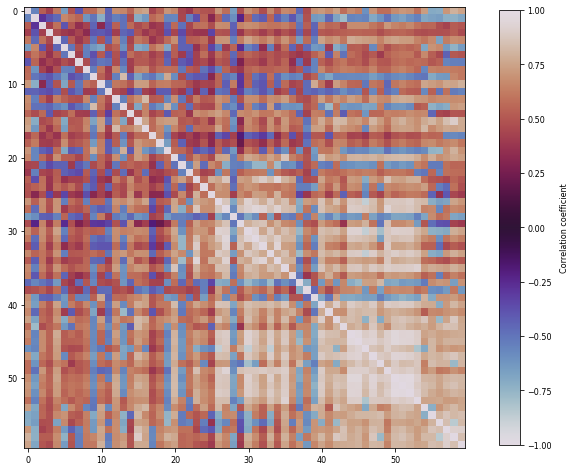

In [20]:
plt.rcParams['image.cmap']='twilight'
plt.figure(figsize=(10,10))
plt.imshow(cc_mat)
cbar = plt.colorbar(pad=.06,shrink=.8)
cbar.set_label('Correlation coefficient',labelpad=8)#,fontsize = 14)

plt.clim(-1,1)

plt.savefig(pathFig + f'Supp_CCMat_top{topF}.png')


In [21]:

def upper_tri_masking(A):
    '''
    Get upper triangle without diagonals
    
    Sample: 
    A = np.array([
     [1,2,3],
     [4,5,6],
     [7,8,9]])
     
    returns: np.array([2,3,6])
    '''
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]

# for k,ccmatK in enumerate(ccmatK_listN):

#     upTri_cc = upper_tri_masking(ccmatK)
    
#     avg_cc = np.mean(upTri_cc)

#     print(f'Cluster {k+1} avg CC:, ',avg_cc) #find CC avg

In [ ]:
topF=50
topF_list = [50]

for topF in topF_list:
    
    catRepN = getTopFCat(cat00N,topF=topF)

    print(f'calculating CC topF = {topF}...')
    cc_matN,lag_matN = calcCCMatrix(catRepN,lenDataN,dataH5_pathN,station,channel,fminN,fmaxN,fsN)
    print(f'saving CC topF = {topF}...')
    np.save(f'../data/interim/ccMat_top{topF}N.npy',cc_mat)


calculating CC topF = 50...


In [ ]:
plt.rcParams['image.cmap']='twilight'
plt.figure(figsize=(50,50))
plt.imshow(cc_matN)
cbar = plt.colorbar(pad=.06,shrink=.8)
cbar.set_label('Correlation coefficient',labelpad=8)#,fontsize = 14)

plt.clim(-1,1)

plt.savefig(pathFig + f'Supp_CCMatN_top{topF}.png')


## average off-diagonal for upper triangle entries...

In [ ]:
# for k,ccmatK in enumerate(ccmatK_listN):

#     upTri_cc = upper_tri_masking(ccmatK)
    
#     avg_cc = np.mean(upTri_cc)

#     print(f'Cluster {k+1} avg CC:, ',avg_cc) #find CC avg

In [ ]:

def upper_tri_masking(A):
    '''
    Get upper triangle without diagonals
    
    Sample: 
    A = np.array([
     [1,2,3],
     [4,5,6],
     [7,8,9]])
     
    returns: np.array([2,3,6])
    '''
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]

# for k,ccmatK in enumerate(ccmatK_listN):

#     upTri_cc = upper_tri_masking(ccmatK)
    
#     avg_cc = np.mean(upTri_cc)

#     print(f'Cluster {k+1} avg CC:, ',avg_cc) #find CC avg